In [39]:
import os
os.chdir('/Users/sarahrandall/Python-outbreak-info/src')
os.getcwd()

'/Users/sarahrandall/Python-outbreak-info/src'

In [35]:
!pip install ..

Processing /Users/sarahrandall/Python-outbreak-info
  Preparing metadata (setup.py) ... done
  Created wheel for python-outbreak-info: filename=python_outbreak_info-2.0.0-py3-none-any.whl size=18324 sha256=7f2f1d0636930cd502f8c38a3ead5f839624091be5d549364846a8e210fbb513
  Stored in directory: /Users/sarahrandall/Library/Caches/pip/wheels/6f/2b/e7/3ed0c40d63901a9ba71e11202a6320922e8c98a9d9afcfcad4
Successfully built python-outbreak-info
  Attempting uninstall: python-outbreak-info
    Found existing installation: python-outbreak-info 2.0.0
    Uninstalling python-outbreak-info-2.0.0:
      Successfully uninstalled python-outbreak-info-2.0.0


In [40]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

matplotlib.rcParams['hatch.linewidth'] = 0.5

'/Users/sarahrandall/Python-outbreak-info/src/outbreak_data'

In [42]:
from outbreak_data import outbreak_data
import outbreak_tools
from outbreak_tools import outbreak_clustering
outbreak_data.print_reqs = True
outbreak_data.default_server = 'dev.outbreak.info'

#### authenticate

In [27]:
#import auth_token

from outbreak_data.authenticate_user import set_authentication
set_authentication(auth_token.get_auth_token())

NameError: name 'auth_token' is not defined

#### pull ww data

In [44]:
state = "Ohio"
state_id = 'USA_US-OH'
startdate, enddate = "2023-09-01", "2023-10-01"
ww_samples = outbreak_data.get_wastewater_samples(region=state_id, date_range=[startdate, enddate])
ww_samples = outbreak_data.get_wastewater_lineages(ww_samples)
ww_samples.loc['2023-09-05', 'BA.2']

GET https://dev.outbreak.info/wastewater_metadata/query?q=geo_loc_region:USA_US-OH AND collection_date:[2023-09-01 TO 2023-10-01] AND demix_success:true AND variants_success:true&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAACAKgBZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=0&fetch_all=true


KeyError: "['_score', '_id'] not found in axis"

In [33]:
ww_abundances = outbreak_tools.datebin_and_agg(ww_samples, weights=outbreak_tools.get_ww_weights(ww_samples), startdate=startdate, enddate=enddate, freq='7D')
ww_abundances['EG.2']

NameError: name 'ww_samples' is not defined

#### pull clinical data

In [33]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state, server='api.outbreak.info')

GET https://dev.outbreak.info/genomics/prevalence-by-location?pangolin_lineage=EG.2&cumulative=false


NameError: Request error (client-side/Error might be endpoint): 403

In [18]:
clinical_abundances = outbreak_tools.datebin_and_agg(clinical_samples, startdate=startdate, enddate=enddate, freq='7D')
clincial_abundances

NameError: name 'clincial_abundances' is not defined

#### get the lineage tree

In [25]:
tree = outbreak_clustering.get_compressed_tree()
lineage_key = outbreak_clustering.get_lineage_key(tree)

AttributeError: module 'frozendict' has no attribute 'deepfreeze'

#### cluster lineages on average abundances

In [27]:
viral_load = outbreak_tools.const_idx(ww_samples, 'viral_load', 1)
viral_load = outbreak_tools.datebin_and_agg(viral_load, startdate=startdate, enddate=enddate, freq='7D', column='normed_viral_load', norm=False)['viral_load']
viral_load

(2023-08-31, 2023-09-07]    2.189894
(2023-09-07, 2023-09-14]    2.443947
(2023-09-14, 2023-09-21]    1.890105
(2023-09-21, 2023-09-28]    1.567893
(2023-09-28, 2023-10-05]    1.642146
(2023-10-05, 2023-10-12]         NaN
(2023-10-12, 2023-10-19]         NaN
(2023-10-19, 2023-10-26]         NaN
(2023-10-26, 2023-11-02]         NaN
(2023-11-02, 2023-11-09]         NaN
(2023-11-09, 2023-11-16]         NaN
(2023-11-16, 2023-11-23]         NaN
(2023-11-23, 2023-11-30]         NaN
(2023-11-30, 2023-12-07]         NaN
(2023-12-07, 2023-12-14]         NaN
(2023-12-14, 2023-12-21]         NaN
(2023-12-21, 2023-12-28]         NaN
Name: viral_load, dtype: float64

In [11]:
ww_abd_data = ww_abundances.mul(viral_load, axis=0)[-6:].sum()
clinical_abd_data = clinical_abundances.mul(viral_load, axis=0)[-6:].sum()
combined_abundances = (ww_abd_data/ww_abd_data.sum()).add(clinical_abd_data/clinical_abd_data.sum(), fill_value=0)

In [12]:
clusters = outbreak_clustering.cluster_lineages(combined_abundances, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### wastewater plots

In [13]:
def format_dateinterval_axis(ax, index, every_n=4):
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, pos: index.get_level_values(0)[x].left.date() ))
    ax.set_xticks(np.arange(0, len(index), every_n))
    ax.set_xlabel(None)

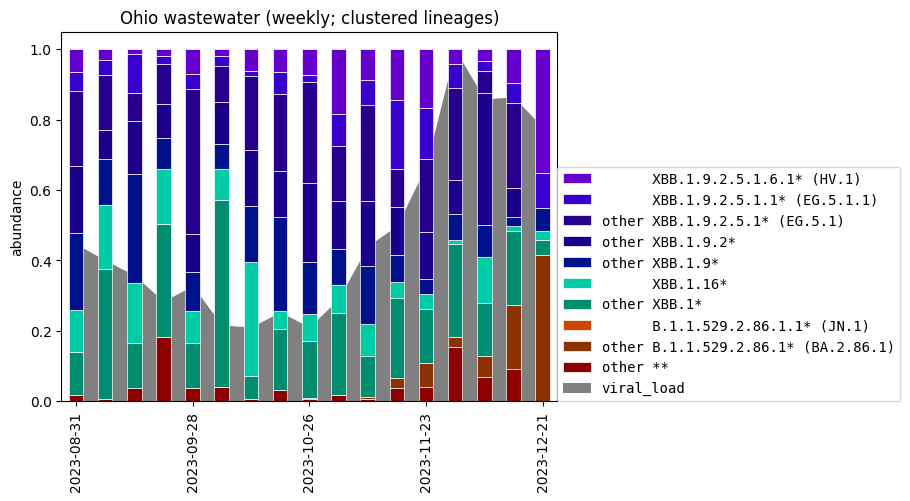

In [14]:
clustered_ww_abundances, root_lineages, isnatural = \
    outbreak_tools.cluster_df(ww_abundances, clusters, tree, lineage_key)
ax = (viral_load / viral_load.max()) \
    .interpolate().bfill().ffill().plot(kind='area', color='gray', linewidth=0)
colors = hsv_to_rgb(outbreak_tools.get_colors(root_lineages, isnatural, lineage_key))
clustered_ww_abundances.plot(
    kind='bar', stacked=True, edgecolor='w', linewidth=.5, color=colors, ax=ax )
format_dateinterval_axis(ax, clustered_ww_abundances.index)
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} wastewater (weekly; clustered lineages)')
plt.show()

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

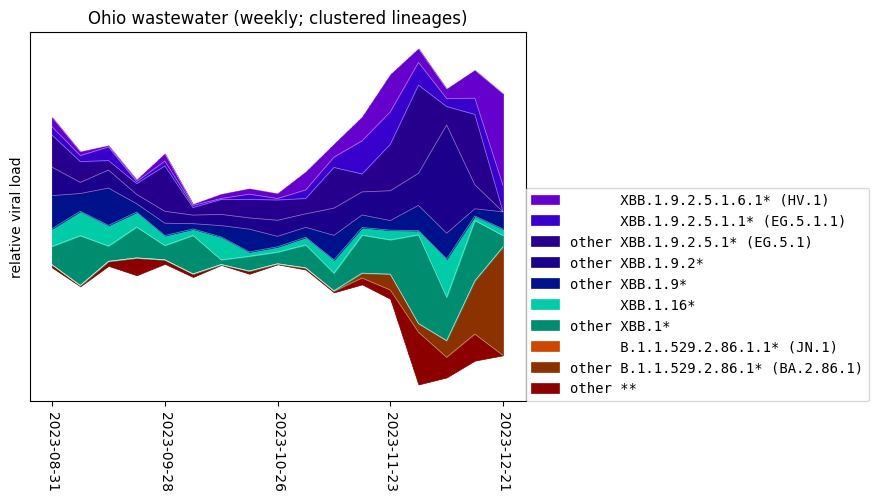

In [16]:
last_line = outbreak_tools.get_riverplot_baseline(clustered_ww_abundances, viral_load)
for lin, color in zip(clustered_ww_abundances.columns, colors):
    next_line = last_line + clustered_ww_abundances[lin] * viral_load.interpolate()
    ix = clustered_ww_abundances[lin].index
    plt.fill_between( ix.astype(str),
                      last_line.interpolate().bfill().ffill(),
                      next_line.interpolate().bfill().ffill(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot( ix.astype(str),
              next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( ix.astype(str),
                      last_line, next_line, color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(plt.gca(), clustered_ww_abundances.index)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} wastewater (weekly; clustered lineages)')

#### clinical plots

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

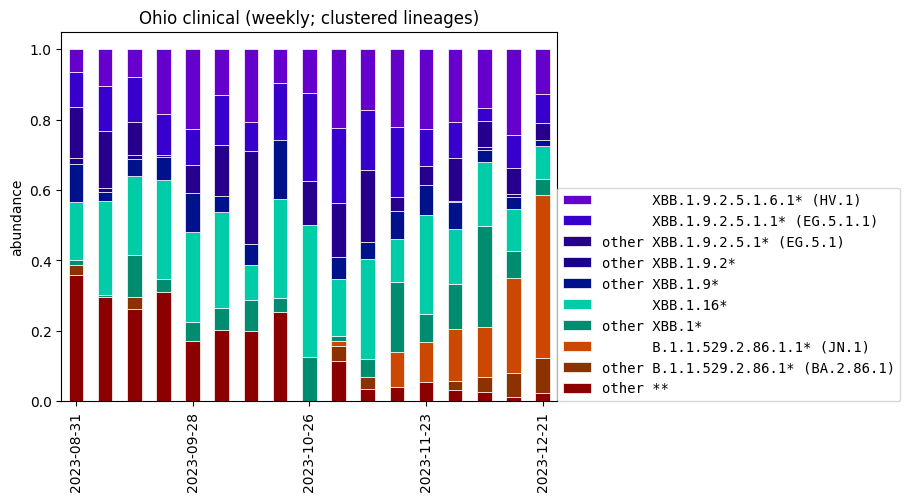

In [17]:
clustered_cl_abundances, root_lineages, isnatural = outbreak_tools.cluster_df(clinical_abundances, clusters, tree, lineage_key)
colors = hsv_to_rgb(outbreak_tools.get_colors(root_lineages, isnatural, lineage_key))
ax = clustered_cl_abundances.plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(ax, clustered_cl_abundances.index)
plt.title(f'{state} clinical (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

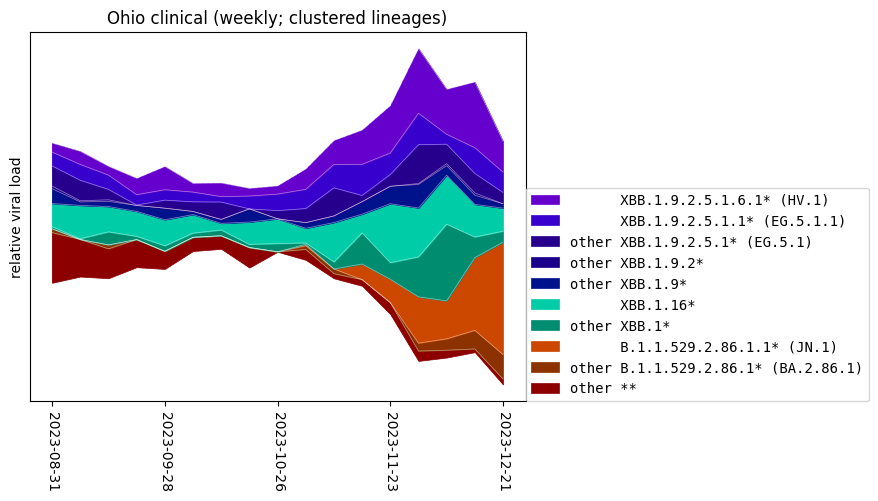

In [18]:
last_line = outbreak_tools.get_riverplot_baseline(clustered_cl_abundances, viral_load)
for lin, color in zip(clustered_cl_abundances.columns, colors):
    next_line = last_line + clustered_cl_abundances[lin] * viral_load.interpolate()
    ix = clustered_cl_abundances[lin].index
    plt.fill_between( ix.astype(str),
                      last_line.interpolate().bfill().ffill(),
                      next_line.interpolate().bfill().ffill(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot( ix.astype(str),
              next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( ix.astype(str),
                      last_line, next_line, color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(plt.gca(), clustered_cl_abundances.index)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} clinical (weekly; clustered lineages)')

#### combined plot

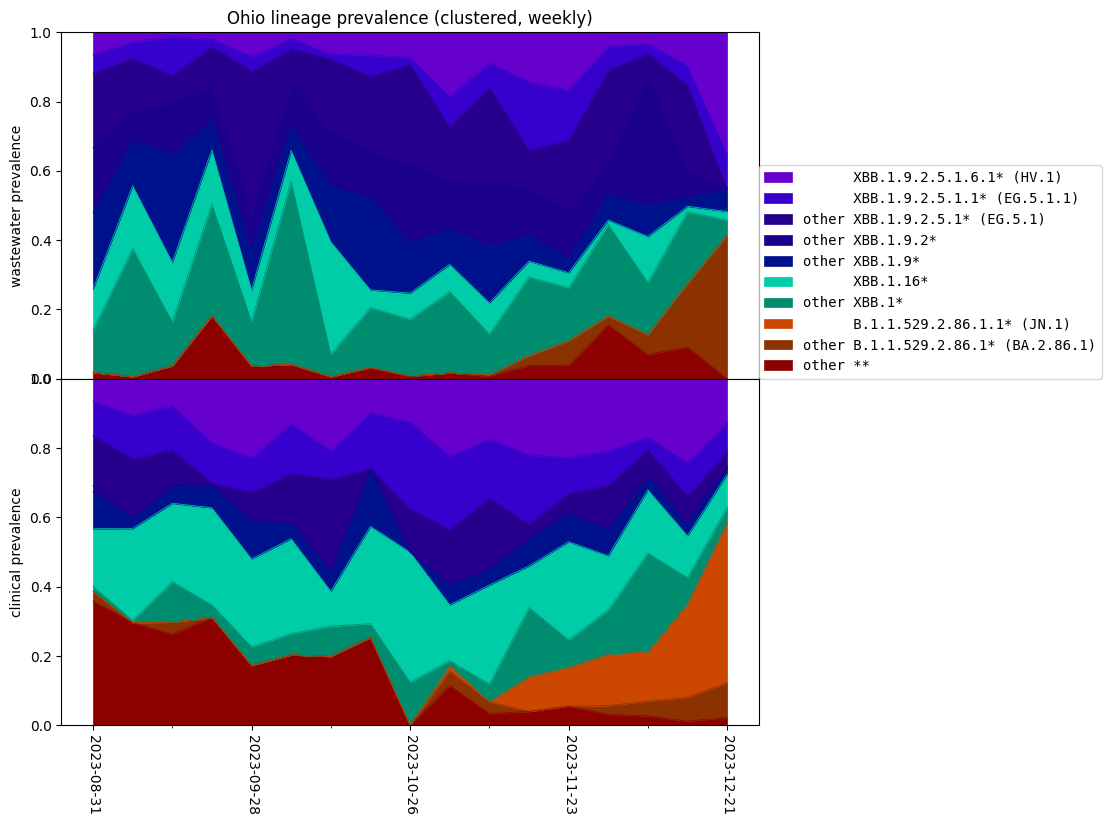

In [35]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

clustered_ww_abundances.plot(kind='area', stacked=True, color=colors, linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('wastewater prevalence')
clustered_cl_abundances.plot(kind='area', stacked=True, color=colors, linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('clinical prevalence')

format_dateinterval_axis(axs[1], clustered_ww_abundances.index)
plt.xticks(rotation=-90)
axs[0].legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
axs[1].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, weekly)')
plt.subplots_adjust(hspace=0)
plt.show()

In [27]:
groups = outbreak_clustering.gather_groups(clusters, combined_abundances)
clustered_abundances = pd.concat([clustered_ww_abundances, clustered_cl_abundances], keys=['A_wastewater', 'B_clinical'])
gcolors = [[colors[root_lineages.index(n['name'])] for n in g] for g in groups]
groups = [ clustered_abundances[
        [clustered_abundances.columns[root_lineages.index(node['name'])] for node in group]
    ].swaplevel(axis='rows').sort_index() for group in groups]
print(groups[1].tail(6))

                                                         other XBB.1.9*  \
(2023-12-07 00:00:00, 2023-12-14 00:00:00] A_wastewater        0.088792   
                                           B_clinical          0.035498   
(2023-12-14 00:00:00, 2023-12-21 00:00:00] A_wastewater        0.024793   
                                           B_clinical          0.033779   
(2023-12-21 00:00:00, 2023-12-28 00:00:00] A_wastewater        0.065169   
                                           B_clinical          0.017927   

                                                         other XBB.1.9.2*  
(2023-12-07 00:00:00, 2023-12-14 00:00:00] A_wastewater          0.375103  
                                           B_clinical            0.007519  
(2023-12-14 00:00:00, 2023-12-21 00:00:00] A_wastewater          0.082649  
                                           B_clinical            0.008403  
(2023-12-21 00:00:00, 2023-12-28 00:00:00] A_wastewater          0.000000  
                  

<Figure size 640x480 with 0 Axes>

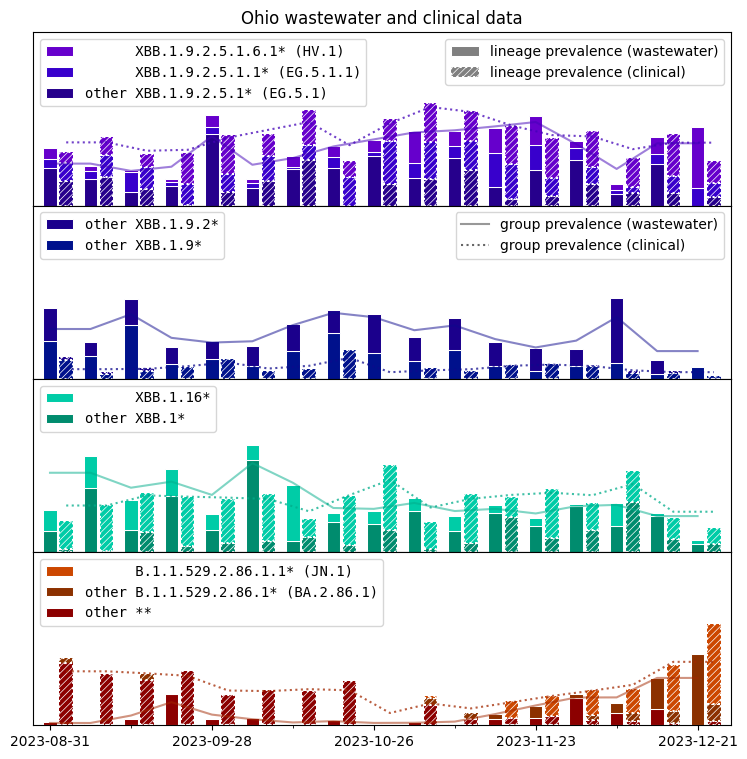

In [19]:
fig, axs = plt.subplots(len(groups),1, sharex=True, figsize=(9,9))
barstyle = { 'linewidth': 0.75, 'edgecolor':'white' }
cbarstyle = { 'linewidth': 1.5, 'linestyle':':', 'hatch': '/////' }
linestyle = { 'alpha': 0.5 }
clinestyle = { 'alpha': 0.75, 'linestyle': ':' }

def trendline(lingroup):
    line = lingroup.sum(axis=1)
    line[lingroup.isna().all(axis=1)] = pd.NA
    line = line.interpolate().rolling(3, closed=None, center=True).mean()/2 + line.interpolate()/2
    return line.bfill().ffill()

for i, (ax, g, c) in enumerate(zip(axs, groups, gcolors)):
    ww = g.xs('A_wastewater', level=1)
    cl = g.xs('B_clinical', level=1)
    ww.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **barstyle)
    ax.add_artist(ax.legend(loc='upper left', prop={"family":"monospace"}, reverse=True)) # save lin legend
    cl.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **(barstyle|cbarstyle))
    for cbar in ax.patches[-cl.size:]: cbar.set_x(cbar.get_x() + 0.4) # x-offset clinical bars
    trendline(ww).plot(color=np.mean(c, axis=0), ax=ax, **linestyle)
    trendline(cl).plot(color=np.mean(c, axis=0), ax=ax, **(linestyle|clinestyle))
    ax.lines[-1].set_xdata(ax.lines[-1].get_xdata() + 0.4) # x-offset clinical trend to match bars
    ax.legend().remove() # skip auto legend
    ax.set_yticks([])
    ax.set_ylim(0,1)

axs[0].set_title(f'{state} wastewater and clinical data')
axs[0].legend([ # custom legend for ww v cl bars
        matplotlib.patches.Patch(facecolor='gray', **barstyle),
        matplotlib.patches.Patch(facecolor='gray', **(barstyle|cbarstyle))],
    ['lineage prevalence (wastewater)', 'lineage prevalence (clinical)'], loc='upper right')
axs[1].legend([ # custom legend for ww v clinical lines
        matplotlib.lines.Line2D([], [], color='#333', **linestyle),
        matplotlib.lines.Line2D([], [], color='#333', **(linestyle|clinestyle))],
    ['group prevalence (wastewater)', 'group prevalence (clinical)'], loc='upper right')
axs[-1].set_xlim(axs[-1].get_xlim()[0], axs[-1].get_xlim()[1] + 0.4)
format_dateinterval_axis(axs[-1], ww.index)
plt.subplots_adjust(wspace=0, hspace=0)